# Installation Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (10,5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\kentw\AppData\Local\Continuum\anaconda3\envs\finrl\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['WE', 'SU', 'TU', 'TH', 'MO', 'SA', 'FR']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import torch
import gym
from tqdm import tqdm

import StockPortfolioEnv
import utils
import TD3_BC

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

C:\Users\kentw\AppData\Local\Continuum\anaconda3\envs\finrl\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [103]:
train_data = pd.read_csv('data/train_data.csv', index_col=0)
trade_data = pd.read_csv('data/trade_data.csv', index_col=0)
full_data = pd.read_csv('data/full_data.csv', index_col=0)

In [104]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal,greedy,mean-var
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,-1.485,-136.781,70.362,-0.272,0.061,0.091,0,0.091
0,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,0.418,184.381,-0.403,1.417,0.091,0.091,0,0.091
0,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,-0.338,13.921,-8.875,30.901,0.015,0.091,0,0.091
0,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,-0.750,92.651,-48.465,30.171,0.045,0.091,0,0.091
0,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,-0.338,-244.724,170.517,38.534,0.167,0.091,0,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,35.890,35.890,35.400,32.854,133500,MLI,4,0.210,33.772,32.589,54.130,8.048,3.167,32.893,32.347,0.131,-35.275,167.986,28.155,0.015,0.091,0,0.000
2768,2017-12-29,49.490,49.760,49.280,45.486,1340300,SEE,4,0.797,46.025,43.477,63.352,103.275,34.896,43.983,42.412,-0.098,-135.890,5.702,50.685,0.076,0.091,0,0.128
2768,2017-12-29,32.341,32.607,32.119,30.584,102872,TR,4,0.039,31.573,30.107,49.152,-49.226,3.944,30.805,30.547,0.660,-87.299,-145.242,45.198,0.152,0.091,0,0.082
2768,2017-12-29,150.450,151.660,149.750,149.860,881900,VRTX,4,1.359,153.807,135.300,52.986,117.528,21.640,145.122,147.850,-0.019,167.509,-82.631,32.756,0.106,0.091,1,0.052


In [8]:
# Environment arguments 
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = full_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [9]:
# Train
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["moribvol"])
retail_portfolio_train = e_train_gym.asset_memory
retail_actions_train = e_train_gym.actions_memory

# Trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data["moribvol"])
retail_portfolio_trade = e_trade_gym.asset_memory
retail_actions_trade = e_trade_gym.actions_memory

# Full
_ = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data["moribvol"])
retail_portfolio_full = env.asset_memory
retail_actions_full = env.actions_memory

begin_total_asset:1000000
end_total_asset:6403619.725722119
Sharpe:  0.8027240438671904
begin_total_asset:1000000
end_total_asset:2441370.145613215
Sharpe:  1.0078092209505938
begin_total_asset:1000000
end_total_asset:15669715.945135742
Sharpe:  0.8588476452597811


In [13]:
X = train_data[tech_indicator_list]
Y = train_data["moribvol"]

X_trade = trade_data[tech_indicator_list]
Y_trade = trade_data["moribvol"]

X_fake_train = train_data[fake_tech_indicator_list]
X_fake_trade = trade_data[fake_tech_indicator_list]

# Model Comparison
> Use a two-stage scheme (supervised learning & reinforcement learning), in analogy to AlphaGo and ChatGPT. The first stage learns from human trader logs, while the second stage leverages reinforcement learning to achieve super-human performance.

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [11]:
# helper functions
def softmax(x):
    """Compute softmax values for each row of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

def plot_portfolio(y1, y2):
    plt.plot(y1, label='model')
    plt.plot(y2, label='Ground Truth')
    plt.scatter(len(y1)-1, y1[-1], color='blue', label='Model last value: {}'.format(y1[-1]))
    plt.scatter(len(y2)-1, y2[-1], color='red', label='Ground Truth last value: {}'.format(y2[-1]))

    plt.legend()
    plt.ylabel('Portfolio Value')
    plt.xlabel('timesteps')
    plt.show()
    
def plot_mse(y1, y2):
    plt.plot(np.mean((y1 - y2.values.reshape(-1, stock_dimension)), axis=1)**2)
    plt.ylabel('MSE')
    plt.xlabel('timesteps')
    plt.show()
    
def ols_return(y1, y2):
    olsres = sm.OLS(pd.Series(y1).pct_change(), sm.add_constant(pd.Series(y2).pct_change()), missing="drop").fit()
    print(olsres.summary())
    
def ols_action(a1, a2):
    olsres = sm.OLS(a1.values, sm.add_constant(a2.reshape(-1))).fit()
    print(olsres.summary())
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data: 
                X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)
        else:
            self.X = torch.tensor(X).float()
            self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Regression

In [117]:
olsres = sm.OLS(Y.values.reshape(-1), sm.add_constant(X.values.reshape(-1, feature_dimension))).fit()

# train
reg_fit = olsres.predict(sm.add_constant(X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_fit = softmax(reg_fit)

# trade
reg_trade = olsres.predict(sm.add_constant(X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_trade = softmax(reg_trade)

begin_total_asset:1000000
end_total_asset:2834879.829353712
Sharpe:  0.5085675601172683


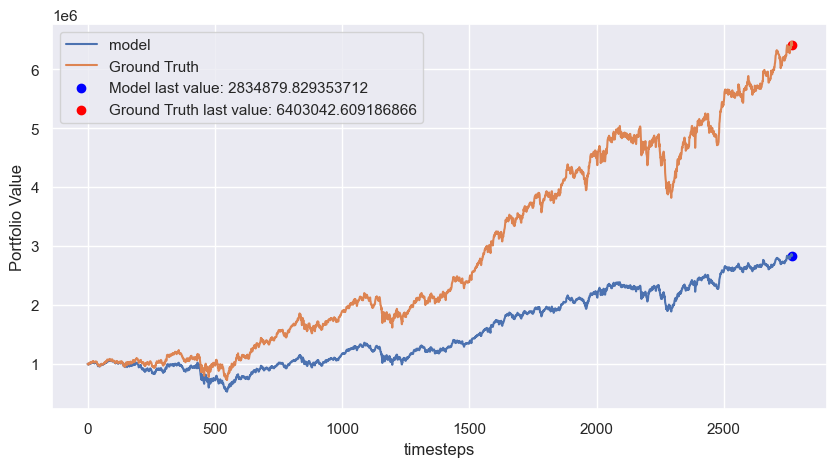

begin_total_asset:1000000
end_total_asset:1797618.2985341903
Sharpe:  0.7071632332582373


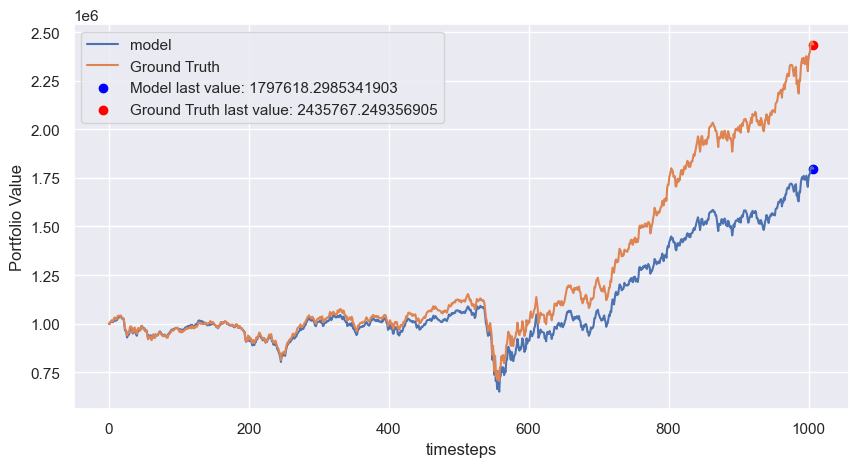

In [118]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=reg_fit)
reg_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, retail_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=reg_trade)
reg_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(reg_portfolio_trade, retail_portfolio_trade)

In [119]:
ols_return(retail_portfolio_train, reg_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.782e+04
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:40:55   Log-Likelihood:                 12400.
No. Observations:                2768   AIC:                        -2.480e+04
Df Residuals:                    2766   BIC:                        -2.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   5.22e-05      5.724      0.0

In [120]:
ols_return(retail_portfolio_trade, reg_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 3.014e+04
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:40:55   Log-Likelihood:                 4465.9
No. Observations:                1007   AIC:                            -8928.
Df Residuals:                    1005   BIC:                            -8918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.06e-05      3.446      0.0

In [121]:
ols_action(train_data["moribvol"], reg_fit)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     78.74
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           7.47e-19
Time:                        21:40:56   Log-Likelihood:                 49366.
No. Observations:               30459   AIC:                        -9.873e+04
Df Residuals:                   30457   BIC:                        -9.871e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4519      0.174     -8.351      0.0

In [122]:
ols_action(trade_data["moribvol"], reg_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.40
Date:                Sun, 30 Apr 2023   Prob (F-statistic):            0.00127
Time:                        21:40:56   Log-Likelihood:                 17967.
No. Observations:               11088   AIC:                        -3.593e+04
Df Residuals:                   11086   BIC:                        -3.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8465      0.291     -2.912      0.0

## RandomForest

In [123]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X, Y)

# train
clf_fit = clf.predict((X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_fit = softmax(clf_fit)

# trade
clf_trade = clf.predict((X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_trade = softmax(clf_trade)

RandomForestRegressor(max_depth=2, random_state=0)

begin_total_asset:1000000
end_total_asset:2832082.918173314
Sharpe:  0.5081802184264346


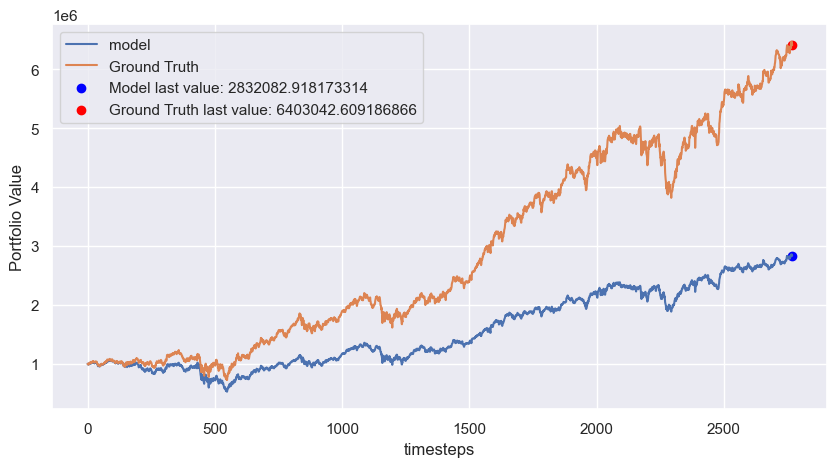

begin_total_asset:1000000
end_total_asset:1797247.777131589
Sharpe:  0.70693030228864


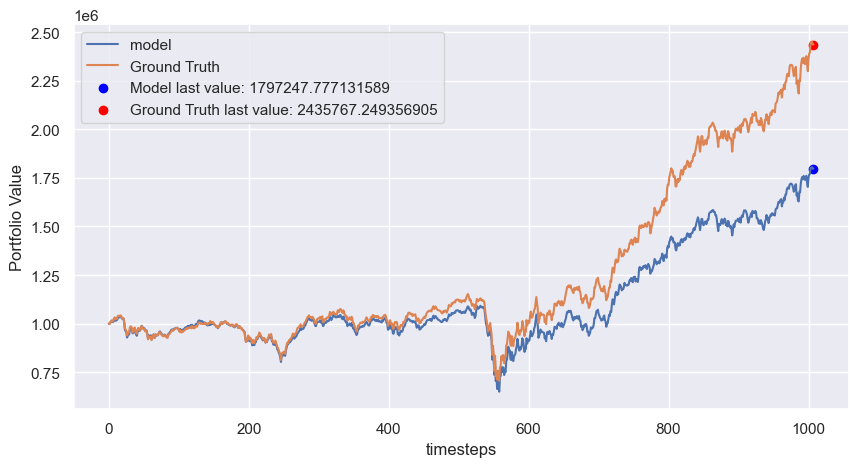

In [124]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=clf_fit)
clf_portfolio_train = e_train_gym.asset_memory
plot_portfolio(clf_portfolio_train, retail_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=clf_trade)
clf_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(clf_portfolio_trade, retail_portfolio_trade)

In [125]:
ols_return(retail_portfolio_train, clf_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.776e+04
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:41:03   Log-Likelihood:                 12399.
No. Observations:                2768   AIC:                        -2.479e+04
Df Residuals:                    2766   BIC:                        -2.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   5.22e-05      5.729      0.0

In [126]:
ols_return(retail_portfolio_trade, clf_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 3.013e+04
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:41:03   Log-Likelihood:                 4465.7
No. Observations:                1007   AIC:                            -8927.
Df Residuals:                    1005   BIC:                            -8918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.06e-05      3.448      0.0

## Deep Models

In [14]:
# Set seeds
seed = 0
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Prepare dataset
X = X.astype(np.float32) 
Y = Y.astype(np.float32) 
X_trade = X_trade.astype(np.float32) 
Y_trade = Y_trade.astype(np.float32)

train_dataset = Dataset(X.values.reshape(-1, stock_dimension*feature_dimension), 
                        Y.values.reshape(-1, stock_dimension))

scaler = StandardScaler(with_mean=True, with_std=True).fit(X.values.reshape(-1, stock_dimension*feature_dimension))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

trade_dataset = Dataset(scaler.transform(X_trade.values.reshape(-1, stock_dimension*feature_dimension)), 
                        Y_trade.values.reshape(-1, stock_dimension),
                        scale_data=False)

full_dataset = Dataset(full_data[tech_indicator_list].values.reshape(-1, stock_dimension*feature_dimension).astype(np.float32), 
                       full_data["moribvol"].values.reshape(-1, stock_dimension).astype(np.float32), 
                       scale_data=False)

[0]

### LSTM

In [128]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return F.softmax(out)

In [129]:
lstm = LSTMModel(input_size=stock_dimension*feature_dimension, 
                 hidden_size=128, 
                 num_layers=1, 
                 output_size=stock_dimension)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:5559128.10261967
Sharpe:  0.7512070187878667


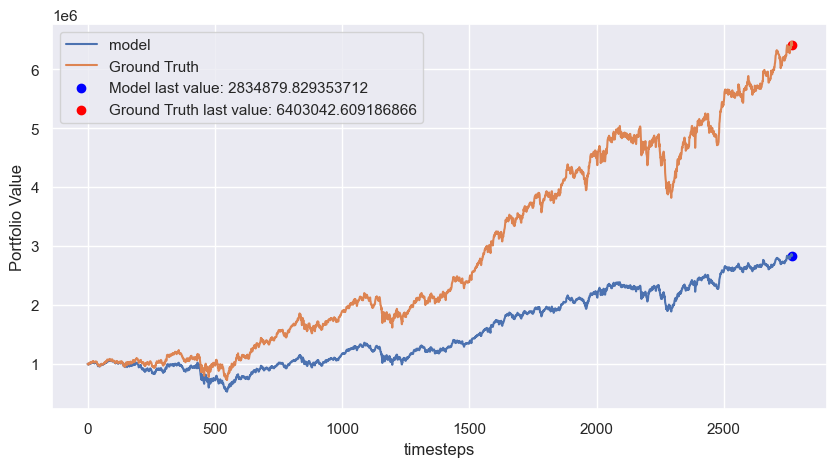

begin_total_asset:1000000
end_total_asset:2011241.8079958519
Sharpe:  0.7325792687634748


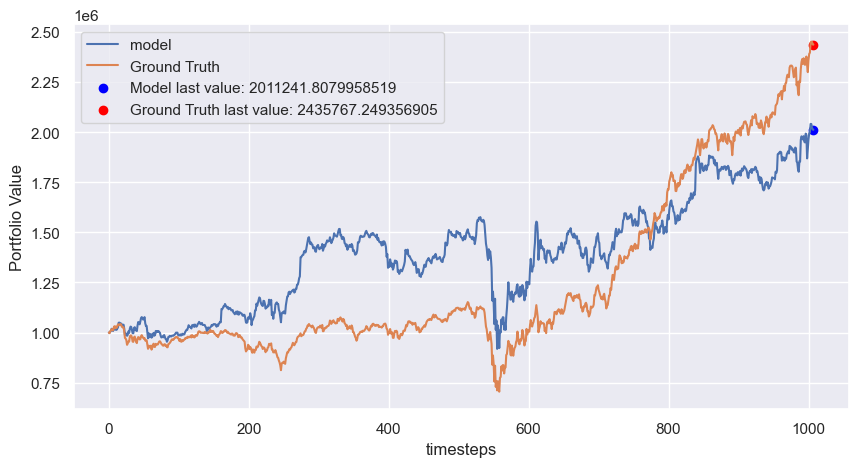

In [130]:
# train
lstm_fit = lstm(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=lstm_fit)
lstm_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, retail_portfolio_train)

# trade
lstm_trade = lstm(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=lstm_trade)
lstm_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(lstm_portfolio_trade, retail_portfolio_trade)

In [131]:
ols_return(retail_portfolio_train, lstm_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.908e+05
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        01:12:23   Log-Likelihood:                 15002.
No. Observations:                2768   AIC:                        -3.000e+04
Df Residuals:                    2766   BIC:                        -2.999e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.266e-05   2.04e-05      2.581      0.0

In [132]:
ols_return(retail_portfolio_trade, lstm_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2343.
Date:                Mon, 01 May 2023   Prob (F-statistic):          7.50e-265
Time:                        01:12:24   Log-Likelihood:                 3342.9
No. Observations:                1007   AIC:                            -6682.
Df Residuals:                    1005   BIC:                            -6672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.431      0.1

### Neural Net

In [19]:
class NeuralNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * F.softmax(self.l3(a))

In [153]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                hidden_dim=256, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 5000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:6692496.523143245
Sharpe:  0.8183597662305035


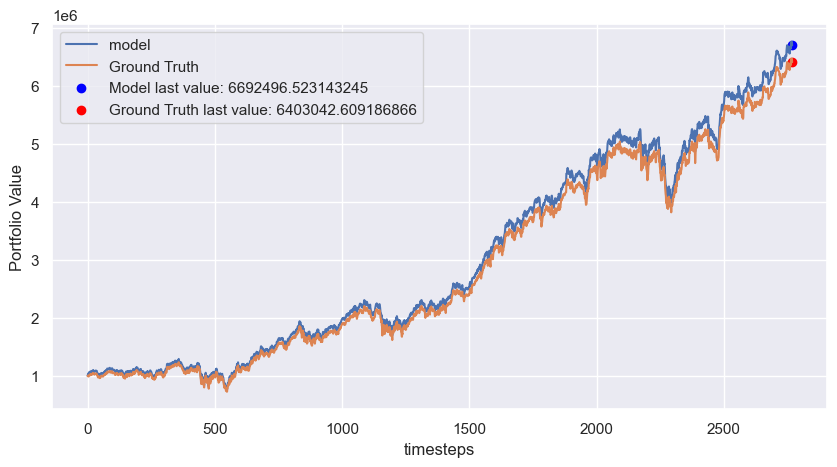

begin_total_asset:1000000
end_total_asset:2407293.126400156
Sharpe:  0.9727820473590053


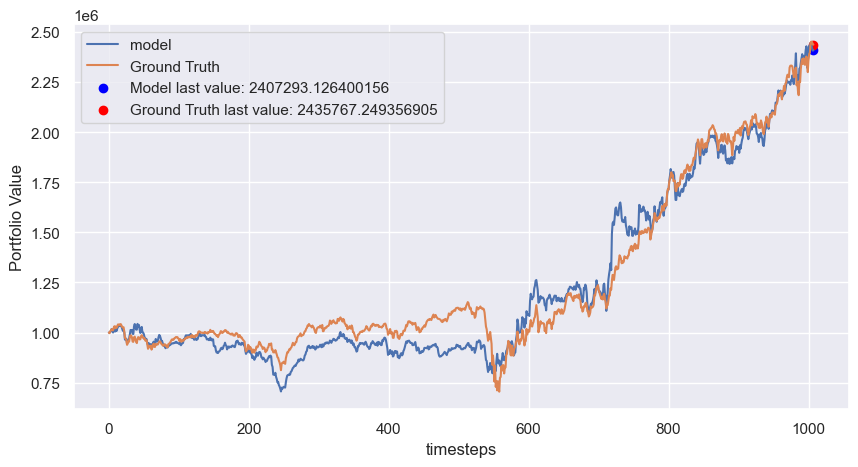

In [154]:
# train
ann_fit = ann(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=ann_fit)
ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(ann_portfolio_train, retail_portfolio_train)

# trade 
ann_trade = ann(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=ann_trade)
ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(ann_portfolio_trade, retail_portfolio_trade)

In [136]:
ols_return(retail_portfolio_train, ann_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 4.629e+05
Date:                Mon, 01 May 2023   Prob (F-statistic):               0.00
Time:                        01:16:09   Log-Likelihood:                 14666.
No. Observations:                2768   AIC:                        -2.933e+04
Df Residuals:                    2766   BIC:                        -2.932e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.045e-05    2.3e-05      1.757      0.0

In [137]:
ols_return(retail_portfolio_trade, ann_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     2307.
Date:                Mon, 01 May 2023   Prob (F-statistic):          1.60e-262
Time:                        01:16:10   Log-Likelihood:                 3337.5
No. Observations:                1007   AIC:                            -6671.
Df Residuals:                    1005   BIC:                            -6661.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.452      0.0

## Rolling Network


In [475]:
_ = StockPortfolioEnv.sample_from_env(i=0, env=backtest_env, weights=rolling_data["moribvol"])

begin_total_asset:1000000
end_total_asset:15260125.37649415
Sharpe:  0.8690869934066863


In [476]:
rolling_ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                hidden_dim=64, 
                max_action=float(e_train_gym.action_space.high[0]))

100%|███████████████████████████████████████████████████████████████████████████████| 141/141 [20:43<00:00,  8.82s/it]

begin_total_asset:1000000
end_total_asset:3051363.396672444
Sharpe:  0.4067559008922079


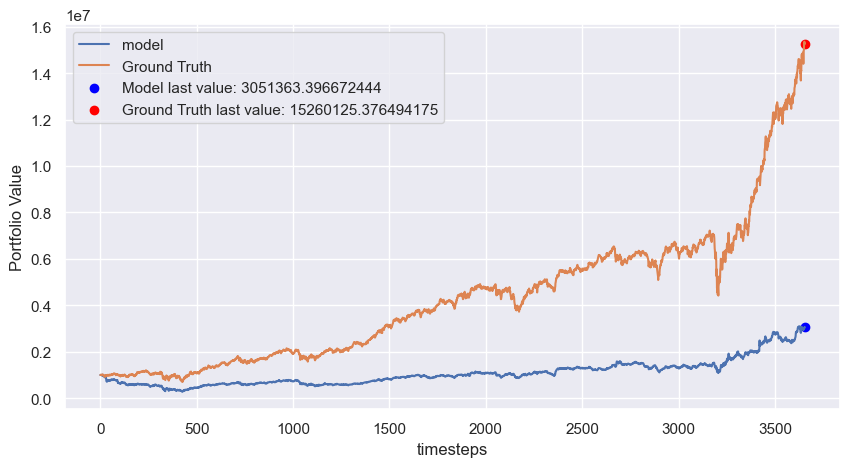

In [481]:
k = 121 # window size
step_size = 26 # step size

rolling_data = full_data.loc[k:] 
rolling_data.index = full_data.loc[k:].index-k
backtest_env = StockPortfolioEnv.StockPortfolioEnv(df = rolling_data, **env_kwargs)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(rolling_ann.parameters(), lr=3e-4)
num_epochs = 1000
num_periods = len(full_dataset)-k

# _ = env.reset()
# actions = full_data["equal"].iloc[:k] # starting window uses equal weights
# for i in range(len(actions)):
#     action = actions.iloc[i].tolist()
#     next_obs, reward, done, _ = env.step(action)

_ = backtest_env.reset()

# populate input and target tensors
for i in tqdm(range(0, num_periods, step_size)):
    rolling_scaler = StandardScaler(with_mean=True, with_std=True).fit(full_dataset.X[i:i+k])
    train_period = Dataset(full_dataset.X[i:i+k], full_dataset.y[i:i+k])
    trade_period = Dataset(rolling_scaler.transform(full_dataset.X[i+k:i+k+step_size]), 
                           full_dataset.y[i+k:i+k+step_size], 
                           scale_data=False)    
    train_dataloader = torch.utils.data.DataLoader(train_period, batch_size=256, shuffle=True)

    # Train the model
    for epoch in range(num_epochs):
        for _, (inputs, targets) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = rolling_ann(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            
            
    ann_rolling_trade = ann(trade_period.X).detach().numpy()
    for j in range(len(ann_rolling_trade)):
        action = ann_rolling_trade[j].tolist()
        next_obs, reward, done, _ = backtest_env.step(action)
        if done: break
            
rolling_portfolio_train = backtest_env.asset_memory
plot_portfolio(rolling_portfolio_train,  retail_portfolio_full[k:] / retail_portfolio_full[k] * 1000000)        

## In a Nutshell

In [138]:
def backtest_helper(ret, data):
    df = pd.DataFrame(ret, columns=['account_value'])
    df['date'] = data['date'].unique()
    perf_stats_all = backtest_stats(df)

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Train')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Trade')

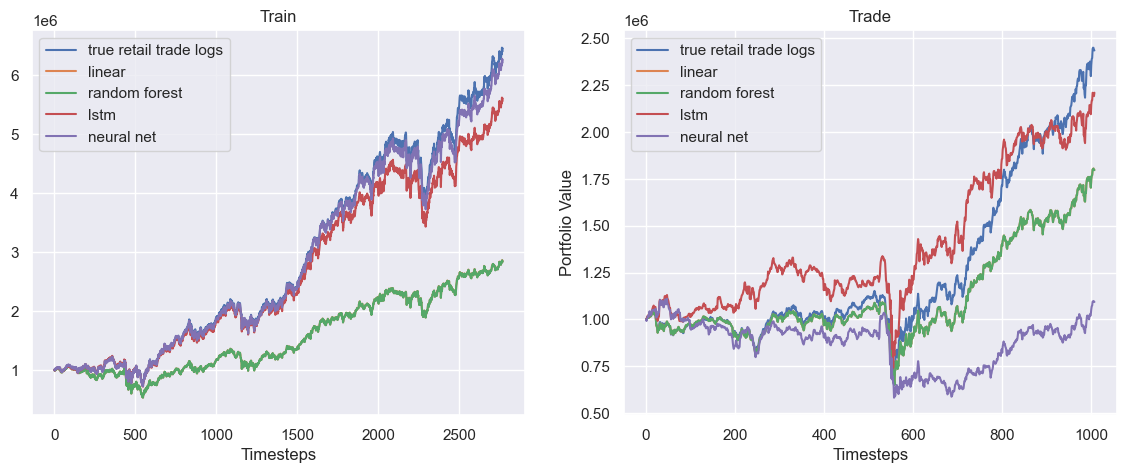

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(retail_portfolio_train, label='true retail trade logs')
axs[0].plot(reg_portfolio_train, label='linear')
axs[0].plot(clf_portfolio_train, label='random forest')
axs[0].plot(lstm_portfolio_train, label='lstm')
axs[0].plot(ann_portfolio_train, label='neural net')
axs[0].set_xlabel('Timesteps')
axs[0].set_title('Train')
axs[0].legend()

axs[1].plot(retail_portfolio_trade, label='true retail trade logs')
axs[1].plot(reg_portfolio_trade, label='linear')
axs[1].plot(clf_portfolio_trade, label='random forest')
axs[1].plot(lstm_portfolio_trade, label='lstm')
axs[1].plot(ann_portfolio_trade, label='neural net')
axs[1].set_ylabel('Portfolio Value')
axs[1].set_xlabel('Timesteps')
axs[1].set_title('Trade')
axs[1].legend()

plt.show()

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Train')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Trade')

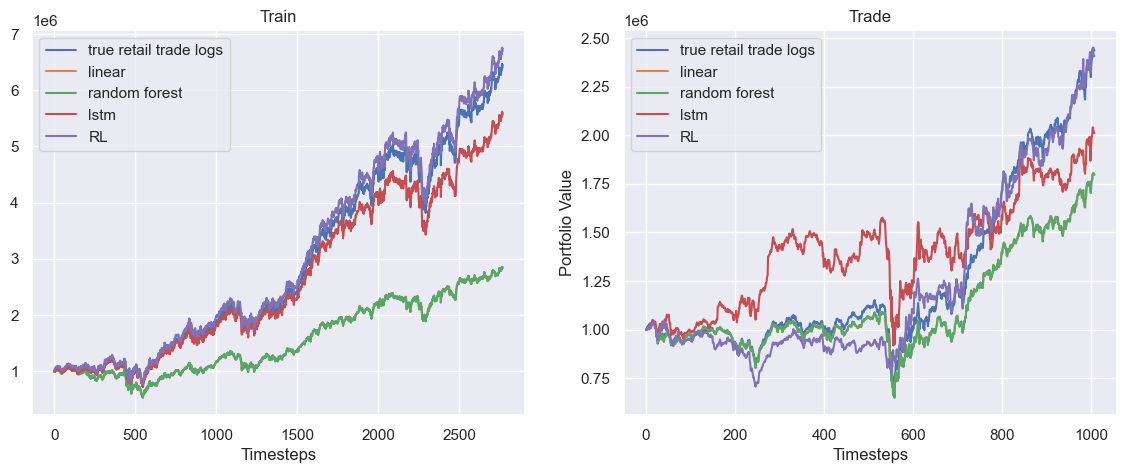

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(retail_portfolio_train, label='true retail trade logs')
axs[0].plot(reg_portfolio_train, label='linear')
axs[0].plot(clf_portfolio_train, label='random forest')
axs[0].plot(lstm_portfolio_train, label='lstm')
axs[0].plot(ann_portfolio_train, label='RL')
axs[0].set_xlabel('Timesteps')
axs[0].set_title('Train')
axs[0].legend()

axs[1].plot(retail_portfolio_trade, label='true retail trade logs')
axs[1].plot(reg_portfolio_trade, label='linear')
axs[1].plot(clf_portfolio_trade, label='random forest')
axs[1].plot(lstm_portfolio_trade, label='lstm')
axs[1].plot(ann_portfolio_trade, label='RL')
axs[1].set_ylabel('Portfolio Value')
axs[1].set_xlabel('Timesteps')
axs[1].set_title('Trade')
axs[1].legend()

plt.show()

In [166]:
backtest_helper(retail_portfolio_train, train_data)

Annual return          0.184
Cumulative returns     5.403
Annual volatility      0.249
Sharpe ratio           0.803
Calmar ratio           0.447
Stability              0.960
Max drawdown          -0.411
Omega ratio            1.161
Sortino ratio          1.185
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.985
Daily value at risk   -0.031
dtype: float64


In [167]:
backtest_helper(reg_portfolio_train, train_data)

Annual return          0.099
Cumulative returns     1.835
Annual volatility      0.246
Sharpe ratio           0.509
Calmar ratio           0.196
Stability              0.885
Max drawdown          -0.509
Omega ratio            1.100
Sortino ratio          0.732
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.965
Daily value at risk   -0.030
dtype: float64


In [168]:
backtest_helper(clf_portfolio_train, train_data)

Annual return          0.099
Cumulative returns     1.832
Annual volatility      0.246
Sharpe ratio           0.508
Calmar ratio           0.195
Stability              0.885
Max drawdown          -0.509
Omega ratio            1.100
Sortino ratio          0.732
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.965
Daily value at risk   -0.031
dtype: float64


In [169]:
backtest_helper(lstm_portfolio_train, train_data)

Annual return          0.169
Cumulative returns     4.559
Annual volatility      0.249
Sharpe ratio           0.751
Calmar ratio           0.401
Stability              0.954
Max drawdown          -0.421
Omega ratio            1.151
Sortino ratio          1.106
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.986
Daily value at risk   -0.031
dtype: float64


In [170]:
backtest_helper(ann_portfolio_train, train_data)

Annual return          0.181
Cumulative returns     5.211
Annual volatility      0.249
Sharpe ratio           0.791
Calmar ratio           0.441
Stability              0.957
Max drawdown          -0.410
Omega ratio            1.159
Sortino ratio          1.168
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.000
Daily value at risk   -0.031
dtype: float64


In [171]:
backtest_helper(retail_portfolio_trade, trade_data)

Annual return          0.249
Cumulative returns     1.436
Annual volatility      0.254
Sharpe ratio           1.006
Calmar ratio           0.643
Stability              0.699
Max drawdown          -0.388
Omega ratio            1.214
Sortino ratio          1.454
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.052
Daily value at risk   -0.031
dtype: float64


In [172]:
backtest_helper(reg_portfolio_trade, trade_data)

Annual return          0.158
Cumulative returns     0.798
Annual volatility      0.253
Sharpe ratio           0.708
Calmar ratio           0.390
Stability              0.574
Max drawdown          -0.404
Omega ratio            1.148
Sortino ratio          1.004
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.978
Daily value at risk   -0.031
dtype: float64


In [173]:
backtest_helper(clf_portfolio_trade, trade_data)

Annual return          0.158
Cumulative returns     0.797
Annual volatility      0.253
Sharpe ratio           0.707
Calmar ratio           0.390
Stability              0.574
Max drawdown          -0.405
Omega ratio            1.148
Sortino ratio          1.004
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.978
Daily value at risk   -0.031
dtype: float64


In [174]:
backtest_helper(lstm_portfolio_trade, trade_data)

Annual return          0.219
Cumulative returns     1.210
Annual volatility      0.287
Sharpe ratio           0.837
Calmar ratio           0.492
Stability              0.787
Max drawdown          -0.445
Omega ratio            1.187
Sortino ratio          1.190
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.127
Daily value at risk   -0.035
dtype: float64


In [105]:
backtest_helper(ann_portfolio_trade, trade_data)

Annual return          0.253
Cumulative returns     1.462
Annual volatility      0.234
Sharpe ratio           1.080
Calmar ratio           0.819
Stability              0.774
Max drawdown          -0.308
Omega ratio            1.214
Sortino ratio          1.640
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.963
Daily value at risk   -0.029
dtype: float64


# Placebo Test

In [158]:
X_fake_train = X_fake_train.astype(np.float32) 
X_fake_trade = X_fake_trade.astype(np.float32) 

fake_train_dataset = Dataset(X_fake_train.values.reshape(-1, stock_dimension*feature_dimension), Y.values.reshape(-1, stock_dimension))
fake_train_dataloader = torch.utils.data.DataLoader(fake_train_dataset, batch_size=256, shuffle=True)
fake_trade_dataset = Dataset(X_fake_trade.values.reshape(-1, stock_dimension*feature_dimension), Y_trade.values.reshape(-1, stock_dimension))

In [159]:
placebo_ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                hidden_dim=128, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(placebo_ann.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = placebo_ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:2694079.102704435
Sharpe:  0.44726985146649284


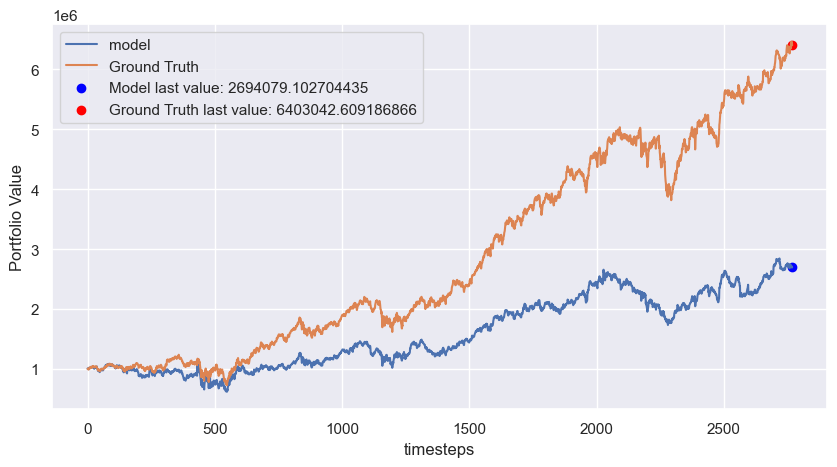

begin_total_asset:1000000
end_total_asset:1540849.0972664012
Sharpe:  0.5153168351008476


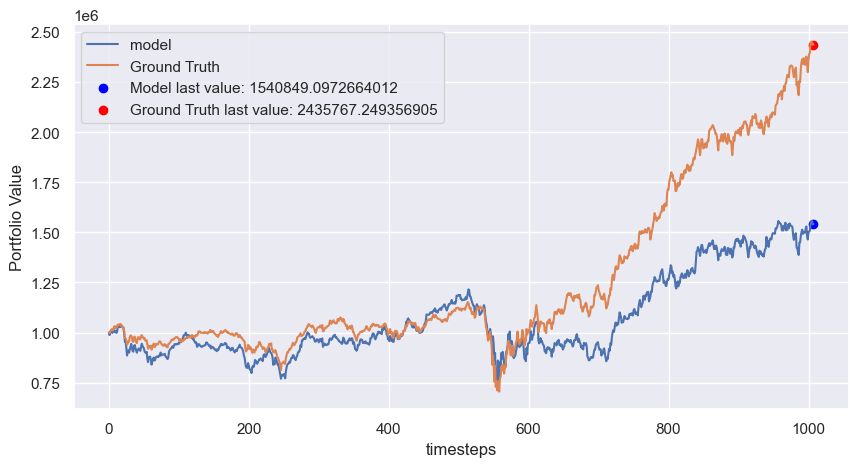

In [160]:
# train
fake_ann_fit = placebo_ann(fake_train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=fake_ann_fit)
fake_ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(fake_ann_portfolio_train, retail_portfolio_train)

# trade 
fake_ann_trade = ann(fake_trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=fake_ann_trade)
fake_ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(fake_ann_portfolio_trade, retail_portfolio_trade)

In [161]:
ols_return(retail_portfolio_train, fake_ann_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     6256.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:22:59   Log-Likelihood:                 9207.7
No. Observations:                2768   AIC:                        -1.841e+04
Df Residuals:                    2766   BIC:                        -1.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.574      0.0

In [162]:
ols_return(retail_portfolio_trade, fake_ann_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1884.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):          1.11e-232
Time:                        09:22:59   Log-Likelihood:                 3268.7
No. Observations:                1007   AIC:                            -6533.
Df Residuals:                    1005   BIC:                            -6524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.997      0.0

# Imitation Ability

In [163]:
# Start from 100th day
train_data = pd.read_csv('data/train_data.csv', index_col=0)
train_data.set_index(train_data.index-100, inplace=True)
train_data = train_data[1100:]

# Environment arguments 
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = full_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [165]:
# Train
mvo_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["mean-var"])
mvo_portfolio_train = e_train_gym.asset_memory
mvo_actions_train = e_train_gym.actions_memory

#Trade
mvo_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=train_data["mean-var"])
mvo_portfolio_trade = e_trade_gym.asset_memory
mvo_actions_trade = e_trade_gym.actions_memory

Y_train_mvo = train_data["mean-var"]
Y_trade_mvo = trade_data["mean-var"]

begin_total_asset:1000000
end_total_asset:1959608.9562568443
Sharpe:  0.36425164837413465
begin_total_asset:1000000
end_total_asset:1495129.4324064078
Sharpe:  0.4660996067275398


In [166]:
# Prepare dataset
Y_train_mvo = Y_train_mvo.astype(np.float32)
Y_trade_mvo = Y_trade_mvo.astype(np.float32)

train_dataset = Dataset(X.values.reshape(-1, stock_dimension*feature_dimension), 
                        Y_train_mvo.values.reshape(-1, stock_dimension))

trade_dataset = Dataset(scaler.transform(X_trade.values.reshape(-1, stock_dimension*feature_dimension)), 
                        Y_trade_mvo.values.reshape(-1, stock_dimension),
                        scale_data=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [173]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                hidden_dim=256, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

In [174]:
# train
ann_fit = ann(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=ann_fit)
ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(ann_portfolio_train, mvo_portfolio_train)

# trade 
ann_trade = ann(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=ann_trade)
ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(ann_portfolio_trade, mvo_portfolio_trade)

begin_total_asset:1000000
end_total_asset:1747959.2158903384
Sharpe:  0.32735171924576006
begin_total_asset:1000000
end_total_asset:2470086.85273287
Sharpe:  0.9174753557542928


In [175]:
ols_action(Y_train_mvo, ann_fit)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.072e+06
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        05:46:41   Log-Likelihood:                 68469.
No. Observations:               29359   AIC:                        -1.369e+05
Df Residuals:                   29357   BIC:                        -1.369e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.000    -11.751      0.0

In [176]:
ols_action(Y_trade_mvo, ann_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     2138.
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        05:46:42   Log-Likelihood:                 9084.1
No. Observations:               11088   AIC:                        -1.816e+04
Df Residuals:                   11086   BIC:                        -1.815e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0631      0.001     53.557      0.0

In [177]:
ols_return(mvo_portfolio_train, ann_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.105e+05
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        05:46:42   Log-Likelihood:                 13919.
No. Observations:                2668   AIC:                        -2.783e+04
Df Residuals:                    2666   BIC:                        -2.782e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.331e-05   2.54e-05      1.704      0.0

In [178]:
ols_return(mvo_portfolio_trade, ann_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1983.
Date:                Mon, 15 May 2023   Prob (F-statistic):          4.85e-240
Time:                        05:46:42   Log-Likelihood:                 2998.6
No. Observations:                1007   AIC:                            -5993.
Df Residuals:                    1005   BIC:                            -5983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -0.968      0.3